In [1]:
import os
import glob
import pickle

import numpy as np
import seaborn as sns
from skimage import io
from scipy.signal import find_peaks, butter, filtfilt
import scipy.io as sio
import matplotlib.pyplot as plt

# Find all minis

In [10]:
from skimage.filters import threshold_otsu

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs # nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def smooth(x, axis=0, wid=5):
    # this is way faster than convolve
    if wid < 2:
        return x
    cumsum_vec = np.cumsum(np.insert(x, 0, 0, axis=axis), axis=axis)
    ma_vec = (cumsum_vec[wid:] - cumsum_vec[:-wid]) / wid
    y = x.copy()
    start_ind = int(np.floor((wid-1)/2))
    end_ind = wid-1-start_ind
    y[start_ind:-end_ind] = ma_vec
    return y

class MiniDetector(object):
    def __init__(self, image_path, save_dir) -> None:
        self.img_path = image_path
        self.save_dir = save_dir
        self.binned_img = None
        self.mask = None
        self.soma_location = None
        self.save_base_name = os.path.basename(self.img_path).split('.')[0]
        self.filtered_traces = None
        self.time_vector = None 
        self.mini_info_list = []

    def bin_image(self, bin_size=8): 
        img = io.imread(self.img_path).astype('float32')
        # permute image in (x,y,t) order
        img = np.transpose(img, (2,1,0))

        binned_img = np.zeros((img.shape[0]//bin_size, img.shape[1]//bin_size, img.shape[2]))
        for i in range(binned_img.shape[0]):
            for j in range(binned_img.shape[1]):
                binned_img[i,j] = np.mean(img[i*bin_size:(i+1)*bin_size, j*bin_size:(j+1)*bin_size], axis=(0,1))
        del img
        self.binned_img = binned_img

    def draw_mask(self):
        mean_img = self.binned_img.mean(2)
        thresh1 = threshold_otsu(mean_img)  # otsu method minimizes intra-class variance
        neuron_mask_1 = mean_img < thresh1  # the iteration here is assuming there are 3 classes, soma, dendrite, background
        img_2 = mean_img[neuron_mask_1]
        thresh = threshold_otsu(img_2)
        neuron_mask = mean_img > thresh
        self.mask = neuron_mask

    def determine_soma_location(self):
        # determine the soma location by finding the center of the neuron mask determined by otsu method
        mean_img = self.binned_img.mean(2)
        thresh = threshold_otsu(mean_img) 
        neuron_mask = mean_img > thresh  # this determines the soma mask
        x = np.where(neuron_mask)[0]
        y = np.where(neuron_mask)[1]
        x_center = np.mean(x)
        y_center = np.mean(y)
        self.soma_location = (x_center, y_center)

    def mask_sanity_check(self):
        mean_img = self.binned_img.mean(2)
        mask = self.mask
        # show both mean_img and mask in two plots and save as one image file
        fig, axs = plt.subplots(1,2)
        axs[0].imshow(mean_img, cmap='gray')
        axs[1].imshow(mask, cmap='gray')
        fig.savefig(os.path.join(self.save_dir, self.save_base_name+'_mask.png'))

    def pre_processing(self, fs=200, cutoff=2, order=5):
        self.bin_image()
        self.draw_mask()
        self.mask_sanity_check()
        assert self.mask.sum() > 0, 'mask is empty, please check the mask'
        neuron_traces = self.binned_img[self.mask]
        neuron_traces = neuron_traces[:, int(fs):] # remove the first 1s of data
        # take the 10th percentile of the mean binned_img as the baseline
        background = np.percentile(self.binned_img.mean(2), 10)
        neuron_traces = neuron_traces - background

        neuron_traces_filt  = butter_lowpass_filter(neuron_traces, cutoff, fs, order)
        dff = (neuron_traces - neuron_traces_filt)/neuron_traces_filt
        self.time_vector = np.arange(neuron_traces.shape[1])/fs
        self.filtered_traces = dff
                

    def find_mini_events(self, threshold=3.5, distance=10):
        """
        threshold: the number of sigmas of the peak above the baseline
        """
        dff = self.filtered_traces
        dff_std = dff.std(1)
        mini_info_list = []
        for trace_id in range(dff.shape[0]):
            peaks, _ = find_peaks(-dff[trace_id], height=dff_std[trace_id]*threshold, distance=10)
            # convert trace_id to x,y coordinates
            x = np.where(self.mask)[0][trace_id]
            y = np.where(self.mask)[1][trace_id]
            if len(peaks) > 0:
                mini_info_list.append({'id':trace_id, 'x':x, 'y':y, 'peaks':peaks, 'dff':dff[trace_id]})
        self.mini_info_list = mini_info_list

    def save_data(self):
        # save the mini_info_list as a pickle file
        with open(os.path.join(self.save_dir, self.save_base_name+'_mini_info_list.pkl'), 'wb') as f:
            pickle.dump(self.mini_info_list, f)
            pickle.dump(self.binned_img, f)
            pickle.dump(self.mask, f)
                
    def plot_traces(self, pixel_id=0, save_file=False):
        # plot the raw trace and the filtered trace
        peaks = self.mini_info_list[pixel_id]['peaks']
        x = self.mini_info_list[pixel_id]['x']
        y = self.mini_info_list[pixel_id]['y']
        dff = self.mini_info_list[pixel_id]['dff']
        # plot the trace with peaks, and the pixel on the binned image
        fig, axs = plt.subplots(2,1)
        axs[0].plot(self.time_vector, dff)
        axs[0].plot(self.time_vector[peaks], dff[peaks], '^')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('dF/F')
        axs[0].set_title('Filtered trace')
        axs[1].imshow(self.binned_img.mean(2), cmap='gray')
        axs[1].plot(y, x, 'x', color='red')
        axs[1].set_title('Pixel location')

        if save_file:
            fig.savefig(os.path.join(self.save_dir, self.save_base_name+'_trace.png'))

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


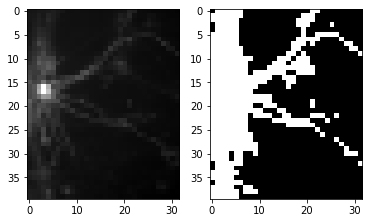

In [35]:
test_img_path = '/Volumes/CLab/dendritic_scaling/test/hSyn-5f-corti-DIV21-Flash4v2-well3-TTXPTX-FOV13p9-482ex-200fps103-93-12092.tif'
save_dir = '/Volumes/CLab/dendritic_scaling/test/results'
test_img_path = '/Users/ykhao/Downloads/mini_analysis/figure5A_neuron_example_nonTTX/rat-hippo-5f-cs1cell1p5-200Hz-currentclamp_rolling fixed_5kfr_cropped.tif'
save_dir = '/Users/ykhao/Downloads/mini_analysis/figure5A_neuron_example_nonTTX/results0p5Hz'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

mini_detector = MiniDetector(test_img_path, save_dir)
mini_detector.pre_processing()
mini_detector.find_mini_events()
mini_detector.save_data()

In [36]:
detected_traces = [item['dff'] for item in mini_detector.mini_info_list]

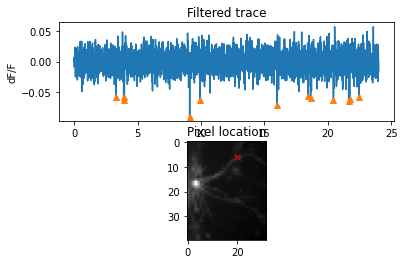

In [52]:
mini_detector.plot_traces(pixel_id=51)

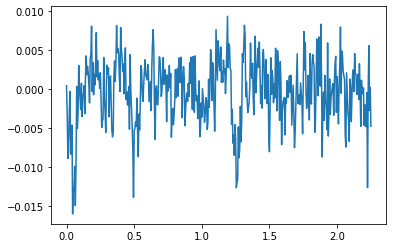

In [166]:
plt.plot(mini_detector.time_vector, np.mean(detected_traces, axis=0))

In [ ]:
img_dir = '/Volumes/CLab/dendritic_scaling/test/'
img_paths = glob.glob(os.path.join(img_dir, '*.tif'))
save_dir = os.path.join(img_dir, 'results')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for img_path in img_paths:
    print('Processing {}'.format(img_path))
    mini_detector = MiniDetector(img_path, save_dir)
    mini_detector.pre_processing()
    mini_detector.find_mini_events()
    mini_detector.save_data()

# Post processing

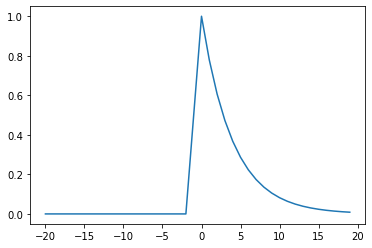

In [2]:
# make the template signal for mini events
t = np.arange(-20, 20, 1)
# for t>0, the signal is exp decay from 1.0, time constant is 3
# for t<0, the signal is zero, and when t=0, the signal is 1
template_signal = np.zeros(len(t))
template_signal[t>=0] = np.exp(-t[t>=0]/4)
template_signal[t==0] = 1
template_signal[t==-1] = 0.5
plt.plot(t, template_signal)

In [3]:
def get_signal_centroid(t, signal):
    # get the centroid of the signal
    # the signal is a 1D array
    # the centroid is the weighted average of the signal
    assert len(t) == len(signal), 't and signal must have the same length'
    centroid = np.sum(signal*t)/np.sum(signal)
    return centroid

class Propagation(object):
    # this class is used to store the propagation information
    # propagation class will have the information of a list of detected mini events
    # And also a method to determine filter out the falsely included mini events according to the peak positions
    def __init__(self, mini_list) -> None:
        self.mini_list = mini_list

    def get_mean_peak(self):
        # get the weighted average of the peak positions
        peak_list = []
        dff_list = []
        for item in self.mini_list:
            peak_list.append(item[2])
            dff_list.append(np.abs(item[3]))
        return np.average(peak_list, weights=dff_list)
    
    def clear_false_events(self, threshold=3):
        # remove the false events by comparing the peak positions
        # if the peak position is too far from the main peak, then remove it
        centroid_center = self.get_mean_peak()
        filtered_mini_list = []
        for item in self.mini_list:
            peak = item[2]
            if abs(peak - centroid_center) <= threshold:
                filtered_mini_list.append(item)
        self.mini_list = filtered_mini_list

    def get_propagation_length(self):
        # get the number of locations involved in the propagation
        return len(self.mini_list)

    def get_mean_waveform(self):
        # get the mean waveform of the propagation
        # first get the mean peak location
        mean_peak = int(np.round(self.get_mean_peak()))
        # then get the mean waveform
        all_trace_near_peak = []
        for item in self.mini_list:
            dff = item[4]
            all_trace_near_peak.append(dff[mean_peak-20:mean_peak+20])
        mean_waveform = np.mean(all_trace_near_peak, axis=0)
        return mean_waveform

    def cross_correlation(self, template_signal):
        # get the cross correlation between the mean waveform and the template signal
        mean_waveform = -self.get_mean_waveform()
        #corr = np.correlate(mean_waveform, template_signal)
        corr = np.sum(mean_waveform*template_signal[:len(mean_waveform)])
        return corr/np.sqrt(np.sum(mean_waveform**2)*np.sum(template_signal**2))


class PropagationDetector(object):
    def __init__(self, mini_info_path) -> None:
        self.mini_info_path = mini_info_path
        self.save_dir = mini_info_path.split('.')[0]
        self.propagation_list = []  # a list of propagation objects
        self.mini_info_list = None
        self.binned_img = None
        self.mask = None
        self.all_peak_locations = None

    def load_data(self):
        with open(self.mini_info_path, 'rb') as f:
            self.mini_info_list = pickle.load(f)
            self.binned_img = pickle.load(f)
            self.mask = pickle.load(f)
        peak_list_of_all_traces = []

        for item in self.mini_info_list:
            peaks = item['peaks']
            peak_list_of_all_traces.append(peaks.tolist())
        
        all_peaks = []
        for item in peak_list_of_all_traces:
            all_peaks += item
        all_peak_unique = np.sort(np.unique(all_peaks))
        all_peak_unique = all_peak_unique[all_peak_unique > 40] # remove the first 40 frames to avoid the artifact
        self.all_peak_locations = all_peak_unique[all_peak_unique < len(self.mini_info_list[0]['dff'])-40]

    
    def find_consecutive_peaks(self, distance=5):
        all_peak_unique = self.all_peak_locations
        if all_peak_unique is None:
            self.load_data()
            all_peak_unique = self.all_peak_locations
        consecutive_peaks_groups = []
        current_group = []
        for i in range(len(all_peak_unique)-1):
            if all_peak_unique[i+1] - all_peak_unique[i] < distance:
                current_group.append(all_peak_unique[i])
            else:
                current_group.append(all_peak_unique[i])
                consecutive_peaks_groups.append(current_group)
                current_group = []
        self.consecutive_peaks_groups = consecutive_peaks_groups
    
    def find_propagation(self, minimal_mini_number=3, template_matching_threshold=0.6):
        for group in self.consecutive_peaks_groups:
            propagation_event = []
            for item in self.mini_info_list:
                peaks = item['peaks']
                dff = item['dff']
                x = item['x']
                y = item['y']
                for peak in peaks:
                    if peak in group:
                        propagation_event.append((x, y, peak, dff[peak], dff))
            propagation = Propagation(propagation_event)
            propagation.clear_false_events()
            template_matching_score = propagation.cross_correlation(template_signal)
            if propagation.get_propagation_length() > minimal_mini_number and template_matching_score > template_matching_threshold:
                self.propagation_list.append(propagation)
    
    def show_propagation(self):
        for propagation in self.propagation_list:
            n_peaks = propagation.get_propagation_length()
            cmaps=sns.color_palette("Set2", n_colors=n_peaks)
            if n_peaks > 15:
                print('Too many peaks, show only the first 15 peaks')
                n_peaks = 15
            fig, axs = plt.subplots(1, n_peaks+2, figsize=(3*n_peaks+6, 5))
            # plot the mean image and the pixel locations
            axs[0].imshow(self.binned_img.mean(2), cmap='gray')
            for i,item in enumerate(propagation.mini_list):
                x = item[0]
                y = item[1]
                axs[0].plot(y, x, 'x', color=cmaps[i])
            # plot the dff trace around each peak
            mean_peak = int(np.round(propagation.get_mean_peak()))
            all_trace_near_peak = []
            for i in range(n_peaks):
                propogation_info = propagation.mini_list
                x = propogation_info[i][0]
                y = propogation_info[i][1]
                peak = propogation_info[i][2]
                dff = propogation_info[i][4]
                show_window = [peak-20,peak+20]
                if show_window[0] < 0:
                    show_window = [0, 40]
                if show_window[1] > len(dff):
                    show_window = [len(dff)-40, len(dff)]
                axs[i+1].plot(np.arange(show_window[0],show_window[1],1), dff[show_window[0]:show_window[1]], color=cmaps[i])
                axs[i+1].set_ylim([-0.15, 0.05])
                axs[i+1].axvline(x=propagation.get_mean_peak(), color='red', linestyle='--')
                axs[i+1].set_title('x={}, y={}'.format(x, y))
                all_trace_near_peak.append(dff[mean_peak-20:mean_peak+20])
            # plot the mean trace
            mean_trace = np.mean(all_trace_near_peak, axis=0)
            axs[-1].plot(np.arange(-20,20,1), mean_trace, color='black')
            axs[-1].set_ylim([-0.15, 0.05])
            axs[-1].set_title('cor={}'.format(propagation.cross_correlation(template_signal)))
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)
            fig.savefig(os.path.join(self.save_dir, 'propagation_{}.png'.format(self.propagation_list.index(propagation))))
            plt.close(fig)

    def save_propagation(self):
        # if the propagation_list is not empty, then save it as a pickle file
        if len(self.propagation_list) > 0:
            with open(os.path.join(self.save_dir, 'propagation_list.pkl'), 'wb') as f:
                pickle.dump(self.propagation_list, f)
    
    def save_propagation_as_mat(self):
        # save the propagation in the propagation list as seperate mat files
        for propagation in self.propagation_list:
            propagation_info = propagation.mini_list
            x = [item[0] for item in propagation_info]
            y = [item[1] for item in propagation_info]
            peak = [item[2] for item in propagation_info]
            dff_around_peak = []
            for item in propagation_info:
                dff_around_peak.append(item[4][item[2]-20:item[2]+20])
            sio.savemat(os.path.join(self.save_dir, 'propagation_{}.mat'.format(self.propagation_list.index(propagation))),
                        {'x':x, 'y':y, 'peak':peak, 'dff_around_peak':dff_around_peak})


In [ ]:
working_dir = '/Volumes/CLab/dendritic_scaling/test/results'
pkl_paths = glob.glob(os.path.join(working_dir, '*.pkl'))
pkl_path = pkl_paths[0]

In [104]:
propagation_detector = PropagationDetector(pkl_path)
propagation_detector.load_data()
propagation_detector.find_consecutive_peaks()
propagation_detector.find_propagation(minimal_mini_number=5)

In [ ]:
propagation_detector.show_propagation(propagation_id=0)

In [55]:
#working_dir = '/Volumes/CLab/dendritic_scaling/20231212_B33-neurons-DIV21_dendritic-scaling/Well2/B33-DIV21-corti-glassbottom-well2-TIFF/results'
working_dir = '/Volumes/CLab/dendritic_scaling/20231212_B33-neurons-DIV21_dendritic-scaling/Well3/B33-DIV21-corti-glassbottom-well3-TIFF/TTX/results'
#working_dir = '/Volumes/CLab/dendritic_scaling/20231212_B33-neurons-DIV21_dendritic-scaling/Well4/B33-DIV21-corti-glassbottom-well4-TIFF/results'
#working_dir = '/Volumes/CLab/dendritic_scaling/test/results'
working_dir = '/Users/ykhao/Downloads/mini_analysis/figure5A_neuron_example_nonTTX/results0p5Hz/'
pkl_paths = glob.glob(os.path.join(working_dir, '*.pkl'))
for pkl_path in pkl_paths:
    propagation_detector = PropagationDetector(pkl_path)
    propagation_detector.load_data()
    propagation_detector.find_consecutive_peaks(distance=5)
    propagation_detector.find_propagation(minimal_mini_number=5, template_matching_threshold=0.75)
    propagation_detector.show_propagation()
    propagation_detector.save_propagation()
    propagation_detector.save_propagation_as_mat()

Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many peaks, show only the first 15 peaks
Too many p

In [ ]:
# image_dir_list = [
#     '/Volumes/CLab/dendritic_scaling/20231215_B33_neurons_DIV24_dendritic_scaling_2/B2-470/B33-DIV24-B2-470-TIFF/TTX',
#     '/Volumes/CLab/dendritic_scaling/20231215_B33_neurons_DIV24_dendritic_scaling_2/B3-470/B33-DIV24-B3-470-TIFF/TTX',
#     '/Volumes/CLab/dendritic_scaling/20231215_B33_neurons_DIV24_dendritic_scaling_2/C2-482/B33-DIV24-C2-482-TIFF/TTX',
#     '/Volumes/CLab/dendritic_scaling/20231215_B33_neurons_DIV24_dendritic_scaling_2/C3-482/B33-DIV24-C3-482-TIFF/TTX',
#     '/Volumes/CLab/dendritic_scaling/20231212_B33-neurons-DIV21_dendritic-scaling/Well2/B33-DIV21-corti-glassbottom-well2-TIFF/TTX',
#     '/Volumes/CLab/dendritic_scaling/20231212_B33-neurons-DIV21_dendritic-scaling/Well3/B33-DIV21-corti-glassbottom-well3-TIFF/TTX',
#     '/Volumes/CLab/dendritic_scaling/20231212_B33-neurons-DIV21_dendritic-scaling/Well4/B33-DIV21-corti-glassbottom-well4-TIFF/TTX']
# image_dir_list = [
#     '/Volumes/MyPassport/dendritic_scaling/20240209/C1_wellB2/TTX_PTX/',
#     '/Volumes/MyPassport/dendritic_scaling/20240209/C1_wellC2/TTX_PTX/',
#     '/Volumes/MyPassport/dendritic_scaling/20240209/C1_wellC3/TTX_PTX/']
# image_dir_list = [
#     '/Volumes/MyPassport/dendritic_scaling/20240210/plateC2_WellB2/TTX_PTX/',
#     '/Volumes/MyPassport/dendritic_scaling/20240210/plateC2_WellB3/TTX_PTX/',
#     '/Volumes/MyPassport/dendritic_scaling/20240210/plateC2_WellC2/TTX_PTX/',
#     '/Volumes/MyPassport/dendritic_scaling/20240210/plateC2_WellC3/TTX_PTX/']
# image_dir_list = [
#     '/Volumes/MyPassport/dendritic_scaling/20240215/plateC3_WellB2/TTX_PTX/',
#     '/Volumes/MyPassport/dendritic_scaling/20240215/plateC3_WellB3/TTX_PTX/',
#     '/Volumes/MyPassport/dendritic_scaling/20240215/plateC3_WellB4/TTX_PTX/',
#     '/Volumes/MyPassport/dendritic_scaling/20240215/plateC3_WellC2/TTX_PTX/',
#     '/Volumes/MyPassport/dendritic_scaling/20240215/plateC3_WellC3/TTX_PTX/']
image_dir_list = [
    '/Volumes/MyPassport/dendritic_scaling/20240216/plateC2_WellB2/',
    '/Volumes/MyPassport/dendritic_scaling/20240216/plateC2_WellB3/',
    '/Volumes/MyPassport/dendritic_scaling/20240216/plateC2_WellC2/',
    '/Volumes/MyPassport/dendritic_scaling/20240216/plateC2_WellC3/']
# image_dir_list = [
#      '/Volumes/MyPassport/dendritic_scaling/20240210/plateC2_WellB2/W-view-images/TTX_PTX/']

for image_dir in image_dir_list:
    pkl_paths = glob.glob(os.path.join(image_dir, 'results', '*.pkl'))
    for pkl_path in pkl_paths:
        propagation_detector = PropagationDetector(pkl_path)
        propagation_detector.load_data()
        propagation_detector.find_consecutive_peaks()
        propagation_detector.find_propagation(minimal_mini_number=5, template_matching_threshold=0.75)
        propagation_detector.show_propagation()
        propagation_detector.save_propagation()
        propagation_detector.save_propagation_as_mat()

In [ ]:
image_dir_list = [
    '/Volumes/MyPassport/dendritic_scaling/20240209/C1_wellB2/TTX_PTX/',
    '/Volumes/MyPassport/dendritic_scaling/20240209/C1_wellC2/TTX_PTX/',
    '/Volumes/MyPassport/dendritic_scaling/20240209/C1_wellC3/TTX_PTX/',
    '/Volumes/MyPassport/dendritic_scaling/20240210/plateC2_WellB2/TTX_PTX/',
    '/Volumes/MyPassport/dendritic_scaling/20240210/plateC2_WellB3/TTX_PTX/',
    '/Volumes/MyPassport/dendritic_scaling/20240210/plateC2_WellC2/TTX_PTX/',
    '/Volumes/MyPassport/dendritic_scaling/20240210/plateC2_WellC3/TTX_PTX/',
    '/Volumes/MyPassport/dendritic_scaling/20240210/plateC2_WellB2/W-view-images/TTX_PTX/']

for image_dir in image_dir_list:
    pkl_paths = glob.glob(os.path.join(image_dir, 'results0p5Hz', '*.pkl'))
    for pkl_path in pkl_paths:
        propagation_detector = PropagationDetector(pkl_path)
        propagation_detector.load_data()
        propagation_detector.find_consecutive_peaks()
        propagation_detector.find_propagation(minimal_mini_number=5, template_matching_threshold=0.75)
        propagation_detector.show_propagation()
        propagation_detector.save_propagation()
        propagation_detector.save_propagation_as_mat()

# post processing -- Dev

In [39]:
working_dir = '/Volumes/CLab/dendritic_scaling/test/results'
pkl_paths = glob.glob(os.path.join(working_dir, '*.pkl'))
pkl_path = pkl_paths[0]
with open(pkl_path, 'rb') as f:
    mini_info_list = pickle.load(f)
    binned_img = pickle.load(f)
    mask = pickle.load(f)

# first filter the mini_info_list based on the peak amplitude
# note to me: we can also ignore the filter here, and filter the propagation events using the number of peaks involved in the event
filter_peaks = False
if filter_peaks:
    filtered_mini_info_list = []
    for item in mini_info_list:
        peaks = item['peaks']
        dff = item['dff']
        thresholded_peaks = peaks[-dff[peaks] > 0.01]  # take the 1% dF/F as the threshold
        if len(thresholded_peaks) > 0:
            filtered_mini_info_list.append(item)
    mini_info_list = filtered_mini_info_list

# second find the propagation events based on the peaks of each trace
peak_list_of_all_traces = []
for item in mini_info_list:
    peaks = item['peaks']
    peak_list_of_all_traces.append(peaks.tolist())

In [40]:
# unpack all the list in the peak_list_of_all_traces to a single list
all_peaks = []
for item in peak_list_of_all_traces:
    all_peaks += item
all_peak_unique = np.sort(np.unique(all_peaks))

In [41]:
# now we have group all the consecutive peaks
consecutive_peaks_groups = []
current_group = []
for i in range(len(all_peak_unique)-1):
    if all_peak_unique[i+1] - all_peak_unique[i] < 5:
        current_group.append(all_peak_unique[i])
    else:
        current_group.append(all_peak_unique[i])
        # if len(current_group) > 1:  # maybe we don't need this, as there might be more events at the same peak
        #     consecutive_peaks_groups.append(current_group)
        consecutive_peaks_groups.append(current_group)
        current_group = []

In [42]:
# a propagation event is defined as a list of (x, y, peak, peak_dff) tuples
# with the consecutive peak groups, we can now find the propagation events
propagation_events = []
for group in consecutive_peaks_groups:
    propagation_event = []
    for item in mini_info_list:
        peaks = item['peaks']
        dff = item['dff']
        x = item['x']
        y = item['y']
        for peak in peaks:
            if peak in group:
                propagation_event.append((x, y, peak, dff[peak], dff))
    propagation_events.append(propagation_event)

In [47]:
filter_propagation_events = True
if filter_propagation_events:
    filtered_propagation_events = []
    for propagation_event in propagation_events:
        if len(propagation_event) > 5:
            filtered_propagation_events.append(propagation_event)
    propagation_events = filtered_propagation_events

In [44]:
cmaps = sns.color_palette("Set2", n_colors=20)
cmaps

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

In [48]:
len(propagation_events)

4

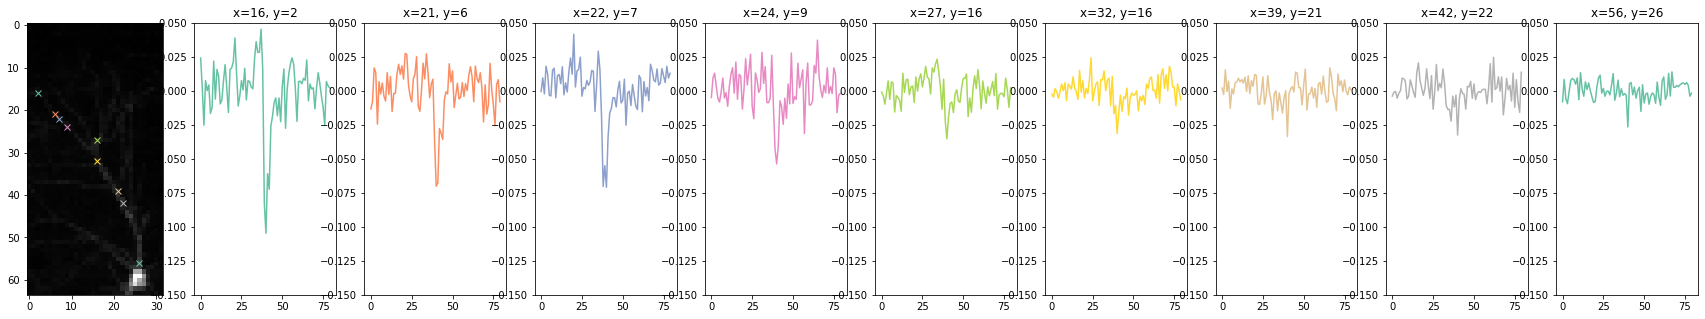

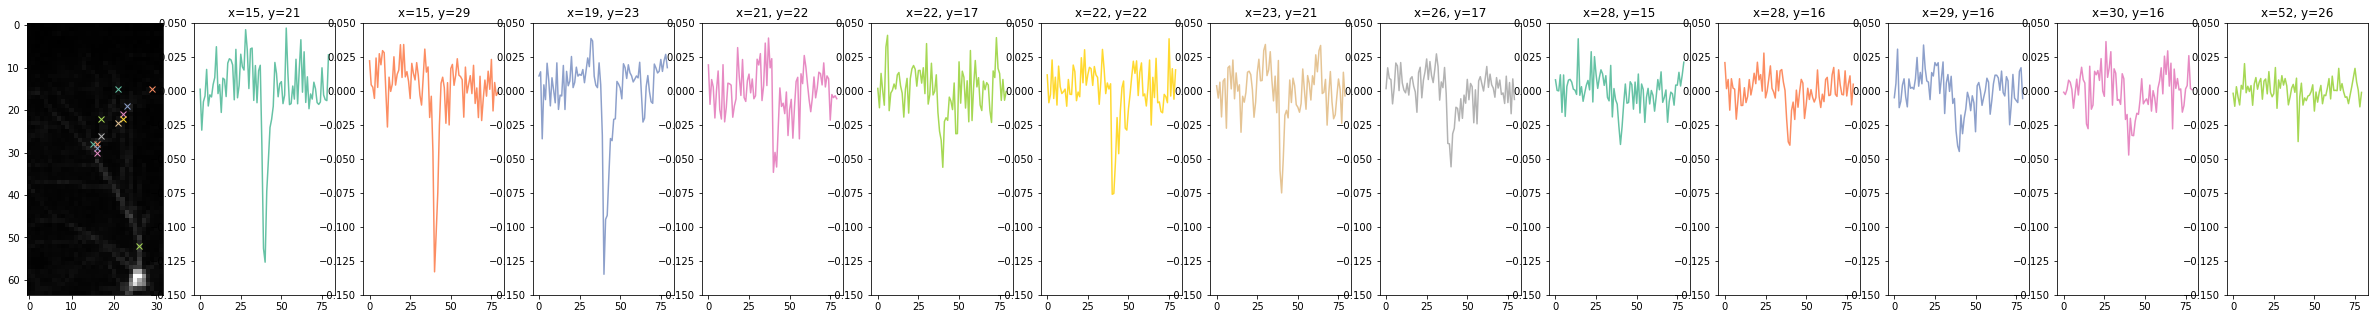

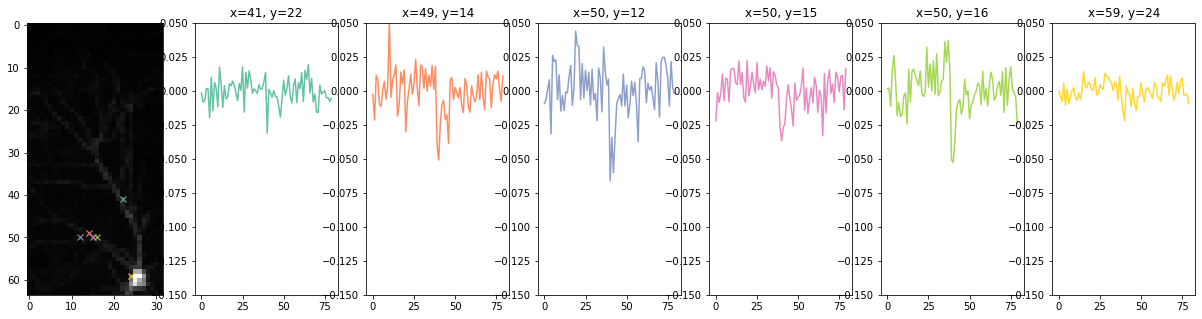

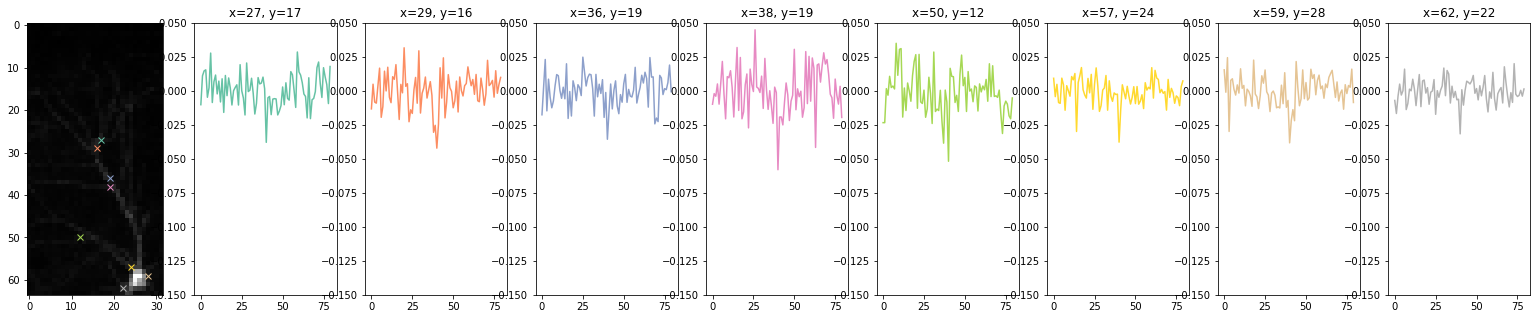

In [49]:
# now we can plot the locations of the propagation events and the dff trace around the peak
# for each propagation event with n peaks, we plot n+1 subplots
# the first plot shows the mean image and each pixel location
# the rest n plots show the dff trace around each peak

for propagation_event in propagation_events:
    n_peaks = len(propagation_event)
    fig, axs = plt.subplots(1, n_peaks+1, figsize=(3*n_peaks+3, 5))
    # plot the mean image and the pixel locations
    axs[0].imshow(binned_img.mean(2), cmap='gray')
    for i,item in enumerate(propagation_event):
        x = item[0]
        y = item[1]
        axs[0].plot(y, x, 'x', color=cmaps[i])
    # plot the dff trace around each peak
    for i in range(len(propagation_event)):
        x = propagation_event[i][0]
        y = propagation_event[i][1]
        peak = propagation_event[i][2]
        dff = propagation_event[i][4]
        axs[i+1].plot(dff[peak-40:peak+40], color=cmaps[i])
        axs[i+1].set_ylim([-0.15, 0.05])
        axs[i+1].set_title('x={}, y={}'.format(x, y))
    fig.savefig(os.path.join(working_dir, 'propagation_event_{}.png'.format(propagation_events.index(propagation_event))))

# dev - event detector

In [5]:
test_img_path = '/Volumes/CLab/dendritic_scaling/test/hSyn-5f-corti-DIV21-Flash4v2-well3-TTXPTX-FOV13p9-482ex-200fps103-93-12092.tif'
os.path.exists(test_img_path)

True

In [6]:
img = io.imread(test_img_path).astype('float32')
# permute image in (x,y,t) order
img = np.transpose(img, (2,1,0))
img.shape

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(512, 256, 12000)

In [7]:
# bin the image 
bin_size = 8
binned_img = np.zeros((img.shape[0]//bin_size, img.shape[1]//bin_size, img.shape[2]))
for i in range(binned_img.shape[0]):
    for j in range(binned_img.shape[1]):
        binned_img[i,j] = np.mean(img[i*bin_size:(i+1)*bin_size, j*bin_size:(j+1)*bin_size], axis=(0,1))

In [8]:
# use otsu threshold to get binary image
from skimage.filters import threshold_otsu
mean_img = binned_img.mean(2)
thresh1 = threshold_otsu(mean_img)  # otsu method minimizes intra-class variance
neuron_mask_1 = mean_img < thresh1  # the iteration here is assuming there are 3 classes, soma, dendrite, background
img_2 = mean_img[neuron_mask_1]
thresh = threshold_otsu(img_2)
neuron_mask = mean_img > thresh

In [9]:
# get the pixel-wise traces from the binary image
neuron_traces = binned_img[neuron_mask]
neuron_traces = neuron_traces[:, 200:] # remove the first 200 frames

In [10]:
# low pass filter the traces to get baseline
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs # nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

fs = 200 # sampling frequency
cutoff = 2 # cutoff frequency
order = 5 # order of filter
neuron_traces_filt = butter_lowpass_filter(neuron_traces, cutoff, fs, order)
t = np.arange(neuron_traces.shape[1])/fs

In [11]:
dff = (neuron_traces - neuron_traces_filt)/neuron_traces_filt
dff_std = dff.std(1)

In [24]:
# find peaks in the dff trace
trace_id = 8
peaks, _ = find_peaks(-dff[trace_id], height=dff_std[trace_id]*4, distance=10)

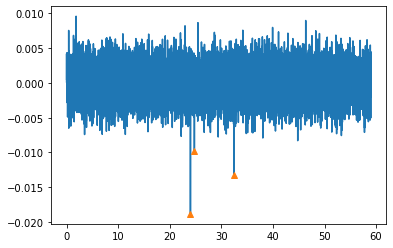

In [25]:
# mark the peak locations on the dff trace
plt.plot(t, dff[trace_id])
plt.plot(t[peaks], dff[trace_id][peaks], '^')

In [73]:
test_img_path = '/Volumes/CLab/dendritic_scaling/test/Corti-hSyn-5f-DIV24-C2-482-TTXPTX-FOV7p9-200fp_rollingshutterfixed_11999fr.tif'
os.path.exists(test_img_path)

True

In [74]:
img = io.imread(test_img_path)
# permute image in (x,y,t) order
img = np.transpose(img, (2,1,0))
img.shape

(512, 256, 11999)

In [75]:
# bin the image 
bin_size = 8
binned_img = np.zeros((img.shape[0]//bin_size, img.shape[1]//bin_size, img.shape[2]))
for i in range(binned_img.shape[0]):
    for j in range(binned_img.shape[1]):
        binned_img[i,j] = np.mean(img[i*bin_size:(i+1)*bin_size, j*bin_size:(j+1)*bin_size], axis=(0,1))

In [79]:
# save the binned_img as a tiff file
io.imsave('/Volumes/CLab/dendritic_scaling/test/binned_img.tif', np.transpose(binned_img, (2,1,0)).astype('uint16'))

/var/folders/2j/4hbq8yj13p1ftfnlwv03r8700000gn/T/ipykernel_28363/1913787017.py:2: UserWarning: /Volumes/CLab/dendritic_scaling/test/binned_img.tif is a low contrast image
  io.imsave('/Volumes/CLab/dendritic_scaling/test/binned_img.tif', np.transpose(binned_img, (2,1,0)).astype('uint16'))


In [77]:
binned_img.shape

(64, 32, 11999)